# ADDRESS MISSING VALUES

* [1. Determine missing values](#determine)
* [2. Decide What To Do With Missing Data](#decide)
    * [2.1 Complete Case Analysis](#complete)
    * [2.2 Mean-Median Imputation](#mean)
    * [2.3 Arbitrary Value Imputation](#arbitrary)
    * [2.4 End Distribution Imputation](#end)
    * [2.5 Frequent Category Imputation](#frequent)
    * [2.6 Missing Category Imputation](#misscat)
    * [2.7 Random Sample Imputation](#random)
    * [2.8 Missing Indicator](#missind)
    * [2.9 Automatic Imputation Method Detection](#auto)


# 1. DETERMINE MISSING VALUES<a class="anchor" id="determine"></a>
All models, with the exception of naive bayes, need to have missing values removed.

In [ ]:
# Missing data may not always be na. May have to make them all similar with:
missing_values = ["n/a", "na", "--"]
df = pd.read_csv("property data.csv", na_values = missing_values)

In [ ]:
# Any missing values?
print(df.isnull().values.any())

# Total number of missing values
print(df.isnull().sum().sum())

In [ ]:
# List of column name and # missing
# index of series is column name
nullSeries = train.isnull().sum()
print('Total NA values:')
print(nullSeries.to_string())

In [ ]:
# Percentage of observations missing per variable

# list of columns that contain missing observations
vars_with_na = [var for var in data.columns if data[var].isnull().mean() > 0]

# calculate the percentage of missing using the isnull() and mean() methods from pandas
data_na = (data[vars_with_na].isnull().mean())*100

# transform the array into a dataframe
data_na = pd.DataFrame(data_na.reset_index())

# add column names to the dataframe
data_na.columns = ['variable', 'na_percentage']

# order the dataframe according to highest to lowest percentage of na per variable
data_na.sort_values(by='na_percentage', ascending=False, inplace=True)

# show begin & end of data
data_na
# or use to print entire thing
print(data_na.to_string())

In [ ]:
# POSSIBLY, CREATE VISUALIZATION OF MISSING VALUES
# We can use seaborn to create a simple heatmap to see where we are missing data
# can see if the missing data is all in 1 column
# If there are a lot of columns, maybe create a new dataframe with just the columns that have missing data then chart

# If you want to modify the new dataframe at all you'll probably want to use .copy() to avoid a SettingWithCopyWarning
# eg. new = old[['A', 'C', 'D']].copy()
nullTrain = train[['date', 'weight', 'resp_1']]

# create heatmap
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

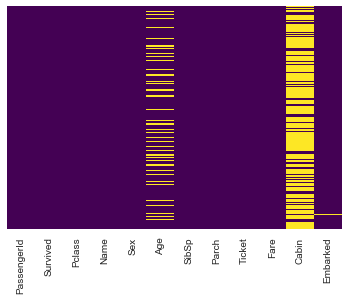

# 2. DECIDE WHAT TO DO WITH MISSING DATA<a class="anchor" id="decide"></a>

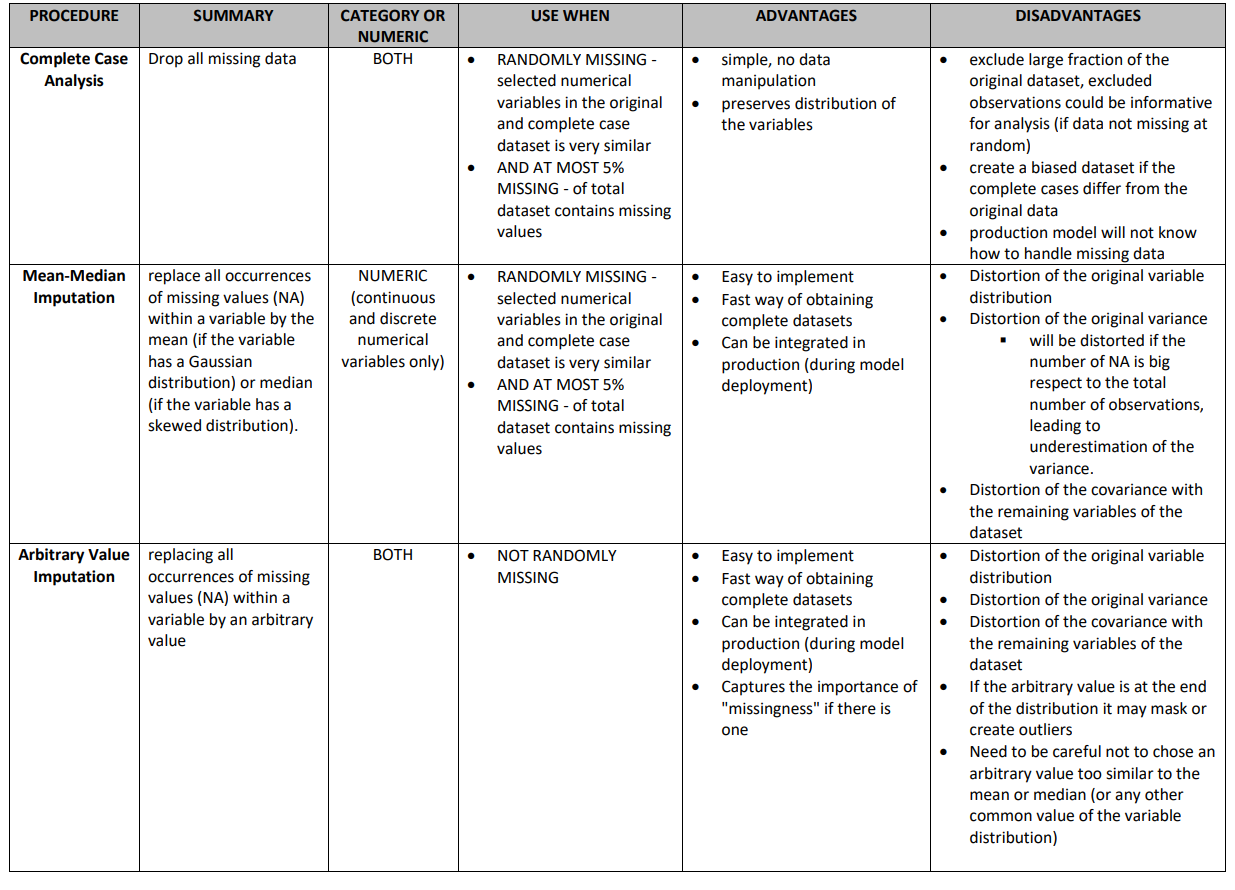

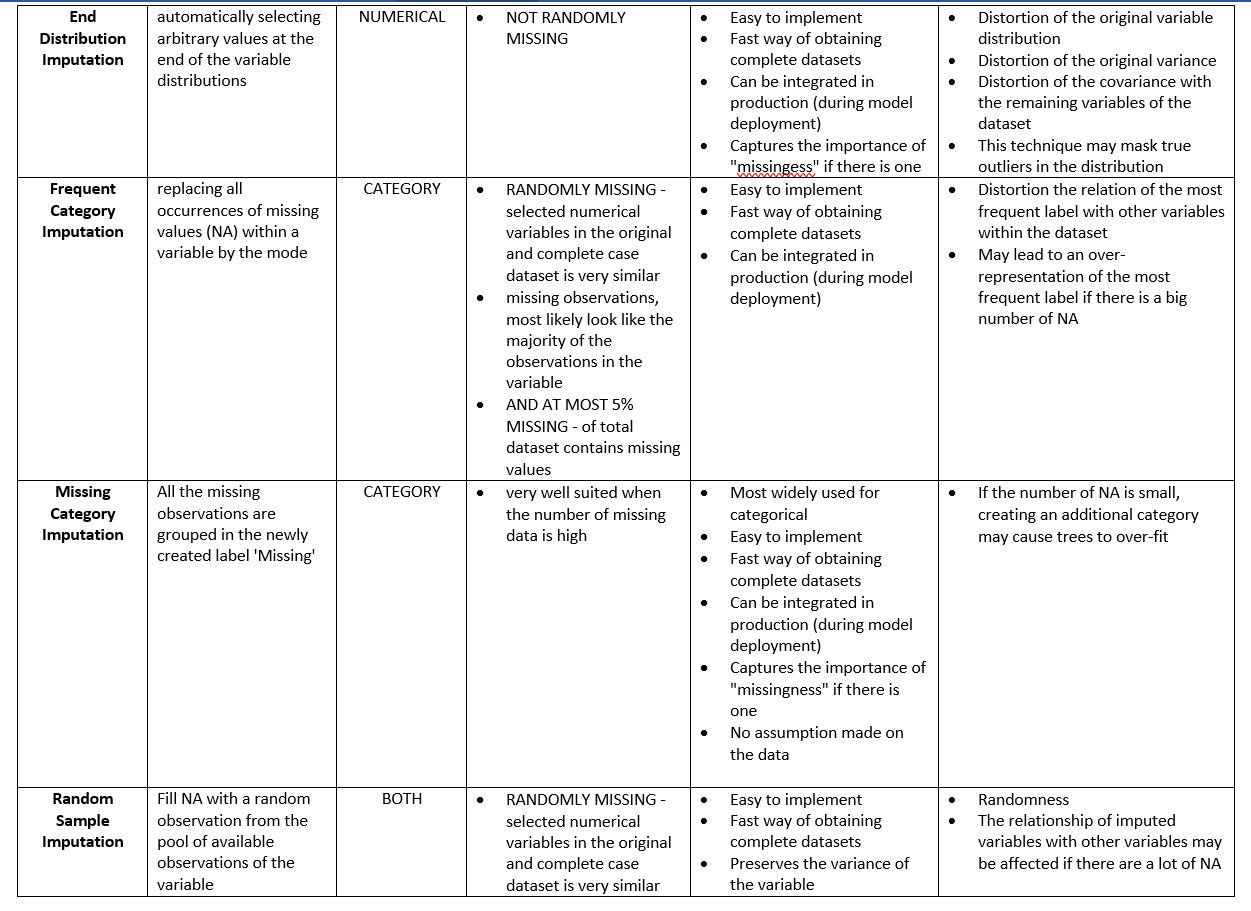

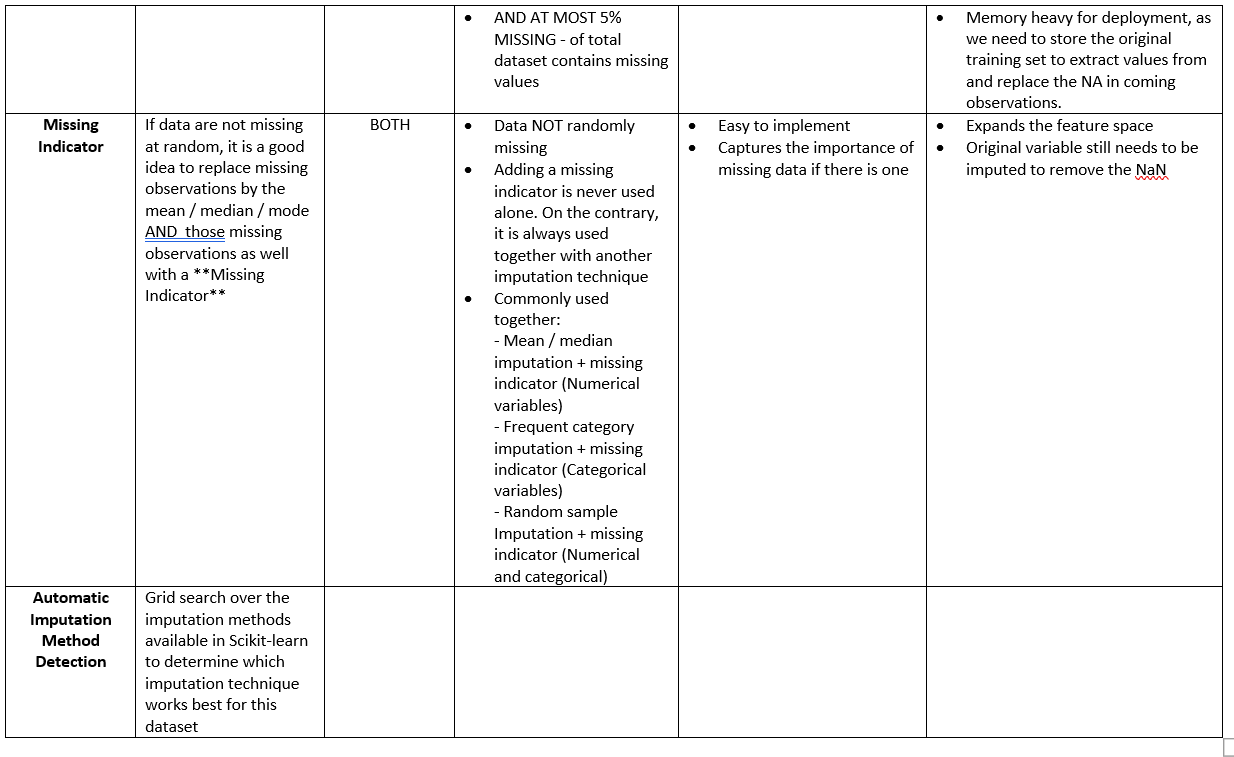

# --------------------------------------------------------------------------------------------------------------

# 2.1 COMPLETE CASE ANALYSIS<a class="anchor" id="complete"></a>
Discard observations where values in any of the variables are missing

###### When to use mean / median imputation?
- CCA can be applied to both categorical and numerical variables
- USE ONLY WHEN: data missing completely at random AND no more than 5% of total dataset contains missing values
    - Knowing about data collection helps decide how to deal with missing data
    - eg of NOT random: more data missing from depressed persons surveys since less motivated to answer

###### Advantages
- simple, no data manipulation
- preserves distribution of the variables

###### Disadvantages
- exclude large fraction of the original dataset, excluded observations could be informative for analysis (if data not missing at random)
- create a biased dataset if the complete cases differ from the original data
- production model will not know how to handle missing data
    - When putting models into production we need to do 1 of 2 things: either we do not score observations with missing data, or we replace the missing values by another number

In [ ]:
# find the variables with missing observations
vars_with_na = [var for var in data.columns if data[var].isnull().mean() > 0]
vars_with_na

In [ ]:
# let's find out whether they are numerical or categorical
data[vars_with_na].dtypes

In [ ]:
# capture variables with no or less than 5% NA
vars_cca = [var for var in data.columns if data[var].isnull().mean() < 0.05]
vars_cca

In [ ]:
# create the complete case dataset - remove observations with na in any variable
data_cca = data[vars_cca].dropna()
print("Shape of dataset BEFORE dropping na = {}\nShape of dataset AFTER dropping na = {}".
format(data.shape, data_cca.shape))

In [ ]:
## with HISTOGRAM: let's check the distribution of a few variables before and after
# can i do this on categorical or just quantitaive?

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
data_cca['GrLivArea'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

In [ ]:
## with DENSITY PLOT: let's check the distribution of a few variables before and after 

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
data['GrLivArea'].plot.density(color='red')

# data after cca
data_cca['GrLivArea'].plot.density(color='blue')

LOOKING FOR: Is the distribution of the selected numerical variables in the original and complete case dataset is very similar? The answer should be yes which means the data is missing at random and only for a small proportion of the observations.

In [ ]:
# the following function captures the percentage of observations for each category in the original and complete case dataset
# and puts them together in a new dataframe

def categorical_distribution(df, df_cca, variable):
    tmp = pd.concat(
        [
            # percentage of observations per category, original data
            df[variable].value_counts() / len(df),

            # percentage of observations per category, cca data
            df_cca[variable].value_counts() / len(df_cca)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'cca']

    return tmp

In [ ]:
# run the following for each categorical cariable
# run for BsmtQual
categorical_distribution(data, data_cca, 'BsmtQual')

The values between original and cca should be very similar.

# --------------------------------------------------------------------------------------------------------------

# 2.2 MEAN / MEDIAN IMPUTATION<a class="anchor" id="mean"></a>

The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

**Note the following**:

- If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for  numerical variables.
- If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
- For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.


###### When to use mean / median imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

Although in theory, the above conditions should be met to minimise the impact of this imputation technique, in practice, mean / median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this, is the simplicity of the technique.

###### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)

###### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
    - will be distorted if the number of NA is big respect to the total number of observations, leading to underestimation of the variance.
- Distortion of the covariance with the remaining variables of the dataset

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected. Mean / median imputation may alter intrinsic correlations since the mean / median value that now replaces the missing data will not necessarily preserve the relation with the remaining variables.

Finally, concentrating all missing values at the mean / median value, may lead to observations that are common occurrences in the distribution, to be picked up as outliers.

###### Final note

Typically, mean / median imputation is done together with adding a binary "missing indicator" variable to capture those observations where the data was missing, thus covering 2 angles: if the data was missing completely at random, this would be captured by the mean /median imputation, and if it wasn't this would be captured by the additional "missing indicator" variable. Both methods are extremely straight forward to implement, and therefore are a top choice in data science competitions.



###### OPTIONS FOR MEAN/ MEDIAN IMPUTATION

###### 1. Create a function

###### 2. Scikit-learn ==> SimpleImputer on entire dataset
    
    Advantages
        - Simple to use if applied to the entire dataframe
        - Maintained by the Scikit-learn developers: good quality code
        - Fast computation (it uses numpy for calculations)
        - Allows for grid search over the various imputation techniques
        - Allows for different missing values encodings (you can indicate if the missing values are np.nan, or zeroes, etc)
    Limitations
        - Returns a numpy array instead of a pandas dataframe, inconvenient for data analysis
        - Needs to use additional classes to select which features to impute  ==>
            - requires more lines of code
            - additional classes still in beta (may change without warning)
            - not so straightforward to use anymore.'
            
###### 3. Scikit-learn ==> ColumnTransformer on specific columns

###### 4. Feature-Engine
    - easy to learn
    - allows you to implement specific engineering steps to specific feature subsets
    - can be integrated with the Scikit-learn pipeline allowing for smooth model building
    - allows you to design and store a feature engineering pipeline with bespoke procedures for different variable groups

# ----------

##### Create a function

In [ ]:
# let's look at the percentage of NA
data.isnull().mean()

In [ ]:
# print the variables that contain missing data

# in the next list comprehension, I loop over all the columns
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum() > 0]

In [ ]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

In [ ]:
# Let's explore the missing data in the train set
# the percentages should be fairly similar to those of the whole dataset
X_train.isnull().mean()

In [ ]:
# let's make a function to fill missing values with the mean or median:
# the variable takes the dataframe, the variable, and the value of the
# mean or median and returns the variable with the filled na

def impute_na(df, variable, mean_median):
    return df[variable].fillna(mean_median)

In [ ]:
# calculate the median Age

median = X_train.age.median()
median

In [ ]:
# calculate the median Age

median = X_train.age.median()
median

In [ ]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
X_train['Age_median'] = impute_na(X_train, 'age', median)

# now replace with the mean
X_train['Age_mean'] = impute_na(X_train, 'age', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
X_train['Age_mean'] = np.round(X_train['Age_mean'], 1)

X_train.head(15)

In [ ]:
# we can see a change in the variance after mean / median imputation
# this is expected, because the percentage of missing data is quite
# high in Age, ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after median imputation: ', X_train['Age_median'].var())
print('Variance after mean imputation: ', X_train['Age_mean'].var())

In [ ]:
# we can see that the distribution has changed 
# with now more values accumulating towards the median
# or median

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['Age_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['Age_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

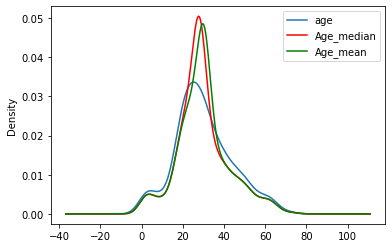

As mentioned above, the mean / median imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the mean / median values.


It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

In [ ]:
# we also said that mean / median imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_median', 'Age_mean']].cov()

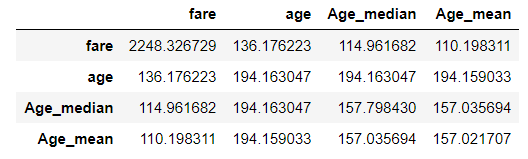

We see indeed that the covariance between Age and Fare is changed after the mean / median imputation.

In [ ]:
# Finally, I mentioned that mean / median imputation may lead 
# to observations that are normal, to look like outliers

# or in other words, mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
X_train[['age', 'Age_median', 'Age_mean']].boxplot()

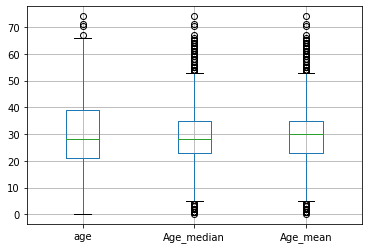

From the boxplot above, we can see that after the imputation not only we have more outliers on the higher Age values, but we have now outliers as well for the lower values of Age.


If we are after true outliers, we need to keep this behaviour in mind, to make sure that we are neither masking nor creating artificial outliers with our imputation technique. In practice, we normally don't check for this behaviour at all. But I think it is important to know that is happening.

# ----------

##### SimpleImputer

In [ ]:
# these are the objects we need to impute missing data
# with sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# to split the datasets
from sklearn.model_selection import train_test_split

In [ ]:
# we use only the following variables for the demo:
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [ ]:
# let's load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

In [ ]:
# let's check the null values
data.isnull().mean()

In [ ]:
LotFrontage    0.177397
OverallQual    0.000000
MasVnrArea     0.005479
BsmtUnfSF      0.000000
TotalBsmtSF    0.000000
1stFlrSF       0.000000
GrLivArea      0.000000
GarageYrBlt    0.055479
WoodDeckSF     0.000000
SalePrice      0.000000
dtype: float64

The variables LotFrontage, MasVnrArea and GarageYrBlt contain missing data.

In [ ]:
# let's separate into training and testing set

# first let's remove the target from the features
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use], # just the features
                                                    data['SalePrice'], # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=0) # for reproducibility
X_train.shape, X_test.shape

In [ ]:
# let's check the misssing data again
X_train.isnull().mean()

In [ ]:
# Now we impute the missing values with SimpleImputer

# create an instance of the simple imputer
# we indicate that we want to impute with the median
# if want to do mean instead, pass 'mean' to 'strategy'
imputer = SimpleImputer(strategy='median')

# we fit the imputer to the train set
# the imputer will learn the median of all variables
imputer.fit(X_train[cols_to_use])

In [ ]:
# we can look at the learnt medians like this:
imputer.statistics_

In [ ]:
# and we can investigate the medians directly to corroborate
# the imputer did a good job
X_train[cols_to_use].median()

**Note** that SimpleImputer learns the medians of ALL the variables in the dataset, those with NA and those without NA.

In [ ]:
# and now we impute the train and test set

# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train

In [ ]:
# if we wanted to continue our data analysis, we would have to
# encode the train set back to a dataframe:

pd.DataFrame(X_train, columns=cols_to_use).head()

In [ ]:
# Let's explore the change in the distributions after the median imputation

X_train = pd.DataFrame(X_train, columns=cols_to_use)
X_train.hist(bins=50, figsize=(10,10))
plt.show()

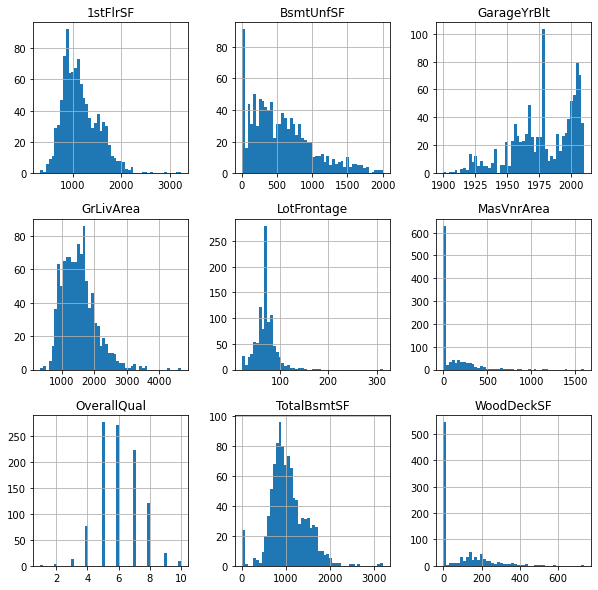

Note in the variable LotFrontAge the tall bar at the value of the median in the histogram, which appears after the data imputation.

**A MASSIVE NOTE OF CAUTION**: when encoding the returned numpy arrays from Scikit-learn back to a dataframe, there is the potential risk of messing the order of the features and therefore MISS-REPRESENTING the data!!

You need to be extremely careful to pass the columns to the pd.DataFrame command in the same order in which they were in the X_train BEFORE the transformation!.

# ----------

##### ColumnTransformer

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],# predictors only
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's look at the missing values
X_train.isnull().mean()

In [ ]:
# let's look at the distributions of the variables to decide
# whether we use the mean or the median

X_train.hist(bins=50, figsize=(10,10))
plt.show()

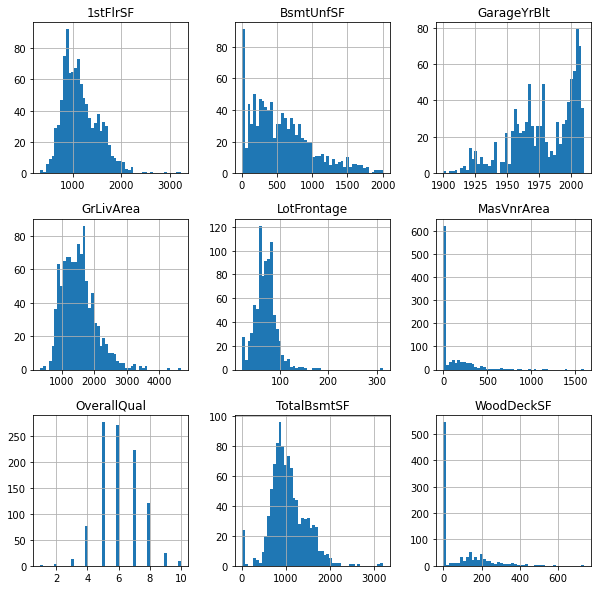

For this demo, I will impute LotFrontage with the mean, and MasVnrArea and GarageYrBlt with the median, as those variables are quite skewed.

In [ ]:
# first we need to make lists, indicating which features
# will be imputed with each method

numeric_features_mean = ['LotFrontage']
numeric_features_median = ['MasVnrArea', 'GarageYrBlt']

# then we instantiate the imputers, within a pipeline
# we create one mean imputer and one median imputer
# by changing the parameter in the strategy

numeric_mean_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

numeric_median_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# then we put the features list and the transformers together
# using the column transformer

# we need to add remainder = True to indicate what we want
# ALL the columns returned at the end of the transformation
# and not just the engineered ones, which is the default
# behaviour of ColumnTransformer. 

preprocessor = ColumnTransformer(transformers=[
    ('mean_imputer', numeric_mean_imputer, numeric_features_mean),
    ('median_imputer', numeric_median_imputer, numeric_features_median)
], remainder='passthrough')


# parameters of the ColumnTransformer
# remainder = 'passthrough' indicates that we want to retain ALL the columns in the dataset
            # otherwise only those specified in the imputing steps will be kept
    
# for more details follow the sklearn page:
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

In [ ]:
# now we fit the preprocessor
preprocessor.fit(X_train)

In [ ]:
# we can explore the transformers like this:

preprocessor.transformers

In [ ]:
# and we can look at the parameters learnt like this:

# for the mean imputer
preprocessor.named_transformers_['mean_imputer'].named_steps['imputer'].statistics_

In [ ]:
# and we can corroborate the value with that one in
# the train set
X_train[numeric_features_mean].mean()

In [ ]:
# for the median imputerthere are 2 values learnt
# because we want to impute 2 different variables

preprocessor.named_transformers_['median_imputer'].named_steps['imputer'].statistics_

In [ ]:
# and we corroborate those values in the train set
X_train[numeric_features_median].median()

In [ ]:
# and now we can impute the data
X_train = preprocessor.transform(X_train)

# and check it worked
np.mean(np.isnan(X_train))

In [ ]:
# and now we can impute the test data
X_test = preprocessor.transform(X_test)

# and check it worked
np.mean(np.isnan(X_test))

In [ ]:
# remember that the returned object  is a NumPy array
X_train

In [ ]:
# if we want to put the array back into a dataframe, we need
# to be careful with the column order

# like this, we can explore the features used in each transformer
# including those in the remainder (the ones that were not transformed)
preprocessor.transformers_

In [ ]:
# let's capture the columns in a list

remainder_cols = [cols_to_use[c] for c in [0, 1, 2, 3, 4, 5]]
remainder_cols

In [ ]:
# capture the data back in a dataframe
pd.DataFrame(X_train,
             columns = numeric_features_mean+numeric_features_median+remainder_cols).head()

**ANOTHER NOTE OF CAUTION**

ColumnTransformer is in essence just slicing the dataframe in the required features. Then the SimpleImputer operates on the sliced dataframe. If different features are required by the different imputation methods, it will slice the dataframe on the required features for each imputation, and then concatenate them to produce the final output.

For our specific example, what happens is the following:

- ColumnTransformer first creates a single column dataframe with the first feature, LotFrontage
- ColumnTransformer creates a 2 column dataframe with the features MasVnrArea and GarageBlt
- ColumnTransformer creates an additional dataframe with the remaining features in the train set
- The SimpleImputers learn the parameters in their respective sliced dataframes
- ColunmnTransformer contatenates back all the dataframes into the final result

# ----------

##### Feature-Engine

Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine captures the numerical variables automatically

In [ ]:
# we call the imputer from feature-engine
# we specify the imputation strategy, median in this case

imputer = mdi.MeanMedianImputer(imputation_method='median')

In [ ]:
# we fit the imputer

imputer.fit(X_train)

In [ ]:
# we see that the imputer found the numerical variables to
# impute with the mean
imputer.variables

In [ ]:
# here we can see the mean assigned to each variable
imputer.imputer_dict_

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables].isnull().mean()

Feature-Engine allows you to specify variable groups easily

In [ ]:
# let's do mean imputation this time
# and let's do it over 2 of the 3 numerical variables

imputer = mdi.MeanMedianImputer(imputation_method='mean',
                                variables=['LotFrontage', 'MasVnrArea'])

imputer.fit(X_train)

In [ ]:
# now the imputer uses only the variables we indicated

imputer.variables

In [ ]:
# and we can see the value assigned to each variable
imputer.imputer_dict_

In [ ]:
# let's corroborate that the dictionary above contains
# the mean values of th variables

X_train[imputer.variables].mean()

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)

# let's check null values are gone
tmp[imputer.variables].isnull().mean()

Feature-Engine can be used with the Scikit-learn pipeline

In [ ]:
pipe = Pipeline([
    ('median_imputer', mdi.MeanMedianImputer(imputation_method='median',
                                             variables = ['LotFrontage', 'GarageYrBlt'])),
     
    ('mean_imputer', mdi.MeanMedianImputer(imputation_method='mean',
                                          variables = ['MasVnrArea'])),
     ])

In [ ]:
pipe.fit(X_train)

In [ ]:
pipe.named_steps['median_imputer'].imputer_dict_

In [ ]:
pipe.named_steps['mean_imputer'].imputer_dict_

In [ ]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

# --------------------------------------------------------------------------------------------------------------

# 2.3 ARBITRARY VALUE IMPUTATION<a class="anchor" id="arbitrary"></a>

Arbitrary value imputation consists of replacing all occurrences of missing values (NA) within a variable by an arbitrary value. Typically used arbitrary values are 0, 999, -999 (or other combinations of 9s) or -1 (if the distribution is positive).


###### Which variables can I impute with an arbitrary value?

Both categorical and numerical variables can be imputed by arbitrary values. 

For categorical variables, this is the equivalent of replacing all instances of NA by an additional label, which is very common practice.

###### Assumptions

- Data is not missing at random.

If this is the case, we want to flag the missing values with a different (arbitrary) value, instead of replacing those occurrences with the mean or the median, which represent the most common value.


###### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingness" if there is one


###### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- If the arbitrary value is at the end of the distribution it may mask or create outliers
- Need to be careful not to chose an arbitrary value too similar to the mean or median (or any other common value of the variable distribution)


###### When to use arbitrary value imputation

Replacing the NA by arbitrary values should be used when there are reasons to believe that the NA are not missing at random. In situations like this, we would not like to replace with the median or the mean, and therefore make the NA look like the majority of our observations. Instead, we want to flag the fact that the observation is missing.

This approach is used widely both in organisations and in Kaggle competitions. It consists of replacing the NA by an arbitrary value. Any of your creation, but ideally different from the median/mean/mode, and not within the normal values of the variable.

The problem consists in deciding which arbitrary value to choose.

###### Final note

When variables are captured by third parties, like credit agencies, they place arbitrary numbers already to signal the fact that the value for that observation is missing. So arbitrary value imputation is also common practice in real life data collections.


###### OPTIONS FOR ARBITRARY VALUE IMPUTATION

###### 1. Create a function

###### 2. SimpleImputer on entire dataset
    Advantages
        - Simple to use if applied to the entire dataframe
        - Maintained by the scikit-learn developers: good quality code
        - Fast computation (it uses numpy for calculations)
        - Allows for grid search over the various imputation techniques
        - Allows for different missing values encodings (you can indicate if the missing values are np.nan, or zeroes, etc)
        
    Limitations
        - Returns a numpy array instead of a pandas dataframe, inconvenient for data analysis
        - Needs to use additional classes to select which features to impute  ==>
            - requires more lines of code
            - additional classes still in beta (may change without warning)
            - not so straightforward to use anymore.
            
###### 3. ColumnTransformer on specific columns

###### 4. Feature-Engine
    Feature-Engine allows you to design and store a feature engineering pipeline with bespoke procedures for different variable groups.



# ----------

In [ ]:
# let's look at the percentage of NA
data.isnull().mean()

Imputation should be done over the training set, and then propagated to the test set. For arbitrary value imputation this is not so important, because we chose the value arbitrarily, however it is good to adhere to this practice and select the arbitrary value by looking only at the distribution of the variables in the train set.

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

In [ ]:
# Let's explore the missing data in the train set 
# the percentages should be fairly similar to those of the whole dataset

X_train.isnull().mean()  

In [ ]:
# let's make a function to fill missing values with an arbitrary value:
# the variable takes the dataframe, the variable, and the value to replace na
# and returns the variable with the filled na

def impute_na(df, variable, value):
    return df[variable].fillna(value)

In [ ]:
# let's explore the distribution of the variables
# to decide which arbitrary value to use

X_train.hist(bins=50)
plt.show()

In [ ]:
# For this demo I will replace NA by 2 different arbitrary values
# one at the far right end of the distribution ==> 99
# and alternatively by -1, taking advantage that Age takes only positive values

# first replace with 99
X_train['Age_99'] = impute_na(X_train, 'age', 99)

# now replace with -1
X_train['Age_minus1'] = impute_na(X_train, 'age', -1)

X_train.head(15)

In [ ]:
# we can see a change in the variance after arbitrary value imputation
# this is expected, because the percentage of missing data is quite
# high in Age ~20%

print('Original variable variance: ', X_train['age'].var())
print('Variance after 99 imputation: ', X_train['Age_99'].var())
print('Variance after -1 imputation: ', X_train['Age_minus1'].var())

- Original variable variance:  194.16304666581863
- Variance after 99 imputation:  888.7051993280913
- Variance after -1 imputation:  307.94005269387753

In fact, the effect on the variance will also be driven by the magnitude of the arbitrary value selected for the imputation, compare 99 with -1.

In [ ]:
# we can see that the distribution has changed 
# with now more values accumulating towards the arbitrary values

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['age'].plot(kind='kde', ax=ax)

# variable imputed with 99
X_train['Age_99'].plot(kind='kde', ax=ax, color='red')

# variable imputed with -1
X_train['Age_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

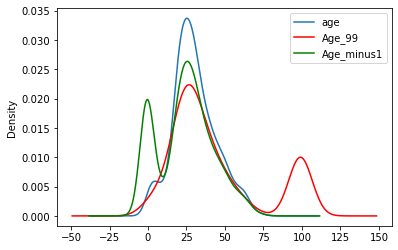

As mentioned above, arbitrary value imputation distorts the original distribution of the variable Age. The transformed variable shows more values around arbitrary values.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Arbitrary value imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree based algorithms.

In [ ]:
# we also said that arbitrary value imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['fare', 'age', 'Age_99', 'Age_minus1']].cov()

In [ ]:
# Finally, I mentioned that arbitrary value imputation may
# affect the perception of outliers

# Let's find out using a boxplot
X_train[['age', 'Age_99', 'Age_minus1']].boxplot()

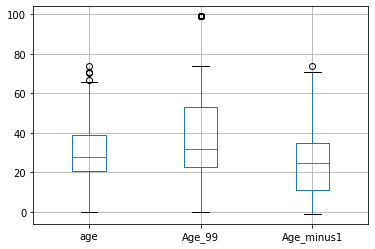

# ----------

##### SimpleImputer

In [ ]:
# these are the objects we need to impute missing data
# with sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# to split the datasets
from sklearn.model_selection import train_test_split

In [ ]:
# we use only the following variables for the demo:
# 3 of which contain NA

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [ ]:
# let's load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

In [ ]:
# let's check the null values
data.isnull().mean()

In [ ]:
LotFrontage    0.177397
OverallQual    0.000000
MasVnrArea     0.005479
BsmtUnfSF      0.000000
TotalBsmtSF    0.000000
1stFlrSF       0.000000
GrLivArea      0.000000
GarageYrBlt    0.055479
WoodDeckSF     0.000000
SalePrice      0.000000
dtype: float64

The variables LotFrontage, MasVnrArea and GarageYrBlt contain missing data.

In [ ]:
# let's separate into training and testing set

# first let's remove the target from the features
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use], # just the features
                                                    data['SalePrice'], # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=0) # for reproducibility
X_train.shape, X_test.shape

In [ ]:
# let's check the misssing data again
X_train.isnull().mean()

# ----------

###### SimpleImputer on the entire dataset

In [ ]:
# Now we impute the missing values with SimpleImputer

# create an instance of the simple imputer
# we indicate that we want to impute with a constant
# arbitrary value: 999
imputer = SimpleImputer(strategy='constant', 
                       fill_value = 999)

# we fit the imputer to the train set
# the imputer assigns 999 to all variables
imputer.fit(X_train)

For arbitrary value imputation, we need to set the strategy to 'constant' and indicate the arbitrary value in the fill_value argument.

In [ ]:
# we can look at the learnt imputation values like this:
imputer.statistics_

In [ ]:
# and now we impute the train and test set

# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train

In [ ]:
# we can transform it back to a dataframe:

X_train = pd.DataFrame(X_train, columns=cols_to_use)
X_train.head()

In [ ]:
# Let's explore the distributions after the imputation

X_train.hist(bins=50, figsize=(10,10))
plt.show()

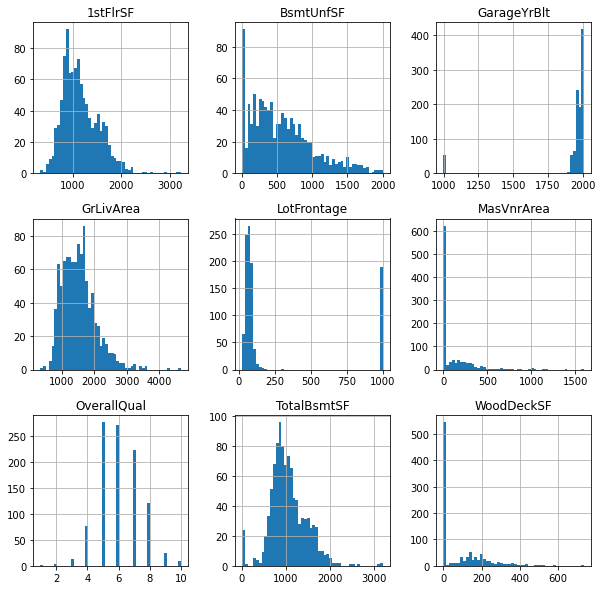

Note the tall bar at 999 in the LotFrontage's histogram, which appeared after the imputation. You can also see the imputation effect on GarageYrBlt, with the bar at the far left right at the 999 value.

**Remember to be cautious with the order in which you pass the column names** as we discussed in the previous notebook.

# ----------

###### ColumnTransformer on Specific Columns

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's look at the missing values
X_train.isnull().mean()

In [ ]:
# let's look at the distributions of the variables to decide
# which arbitrary value to use for each feature

X_train.hist(bins=50, figsize=(10,10))
plt.show()

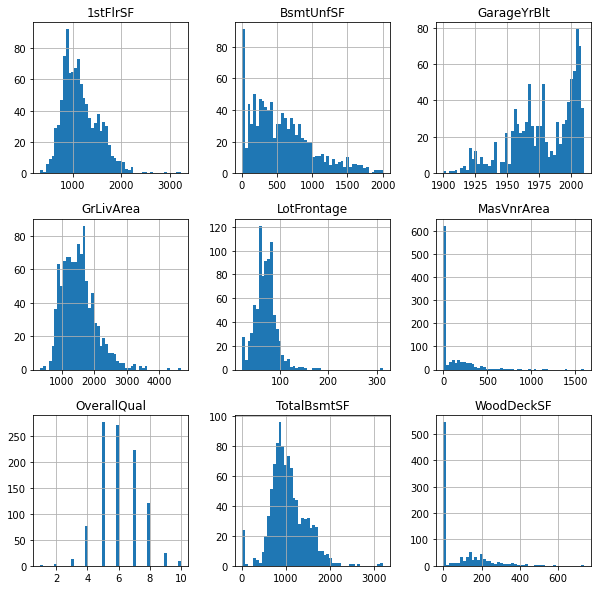

For this demo, I will impute each of LotFrontage, MasVnrArea and GarageYrBlt with different arbitrary values.

In [ ]:
# first we need to make lists, indicating which features
# will be imputed with each value

features_LotFrontAge = ['LotFrontage']
features_MasVnrArea = ['MasVnrArea']
features_GarageYrBlt = ['GarageYrBlt']

# then we instantiate the imputers, within a pipeline
# we create one imputer per feature
# within the imputer I indicate the arbitrary value
# which is differet for each variable

imputer_LotFrontAge = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 999)),
])

imputer_MasVnrArea = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = -10)),
])

imputer_GarageYrBlt = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 1700)),
])

# then we put the features list and the transformers together
# using the column transformer

# in this example, I will use the default parameter of ColumnTransformer
# remainder = drop, which means that only the imputed features will
# be retained, and the rest dropped

preprocessor = ColumnTransformer(transformers=[
    ('imputer_LotFrontAge', imputer_LotFrontAge, features_LotFrontAge),
    ('imputer_MasVnrArea', imputer_MasVnrArea, features_MasVnrArea),
    ('imputer_GarageYrBlt', imputer_GarageYrBlt, features_GarageYrBlt)
],remainder = 'drop')

In [ ]:
# now we fit the preprocessor
preprocessor.fit(X_train)

In [ ]:
# we can explore the transformers like this:

preprocessor.transformers

In [ ]:
# and we can look at the parameters learnt like this:

# for LotFrontAge
preprocessor.named_transformers_['imputer_LotFrontAge'].named_steps['imputer'].statistics_

In [ ]:
# for MasVnrArea

preprocessor.named_transformers_['imputer_MasVnrArea'].named_steps['imputer'].statistics_

In [ ]:
# and now we can impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train

In [ ]:
array([[ 999.,  573., 1998.],
       [ 999.,    0., 1996.],
       [  50.,    0., 1700.],
       ...,
       [  68.,    0., 1978.],
       [ 999.,   18., 2003.],
       [  58.,   30., 1998.]])

Observe how the returned data contains only 3 variables, the ones for which we specified imputation values. This is the effect of specifying remainder='drop' in the columnTransformer.

**ANOTHER NOTE OF CAUTION**

ColumnTransformer is in essence just slicing the dataframe in the required features. Then the SimpleImputer operates on the sliced dataframe. If different features are required by the different imputation methods, it will slice the dataframe on the required features for each imputation, and then concatenate them to produce the final output.

For our specific example, what happens is the following:

- ColumnTransformer first creates 3 single column dataframes, one with each of the indicated variables
- The SimpleImputers learn the parameters in their respective sliced dataframes
    - In this case they don't learn anything, because we hard code the arbitrary value
- ColunmnTransformer contatenates back the 3 single column dataframes into the final result, which is a 3 column dataframe

So note that you will not get all the variables from the original X_train, unless you create imputers for all the variables!!

Also, there is a risk of messing up with the order of the features, if we do not use the transformers within a pipeline or we do not keep an eye on the order of the features in the train set, before they were converted to numpy arrays.

In [ ]:
# see how the result of the imputation is a 3 column dataset
pd.DataFrame(X_train,
             columns=features_LotFrontAge + features_MasVnrArea +
             features_GarageYrBlt).head()

	LotFrontage	MasVnrArea	GarageYrBlt
0	999.0	573.0	1998.0
1	999.0	0.0	1996.0
2	50.0	0.0	1700.0
3	60.0	0.0	1939.0
4	60.0	0.0	1930.0

In [ ]:
X_train = pd.DataFrame(X_train,
             columns=features_LotFrontAge + features_MasVnrArea +
             features_GarageYrBlt)

X_train.hist(bins=50, figsize=(10,10))
plt.show()

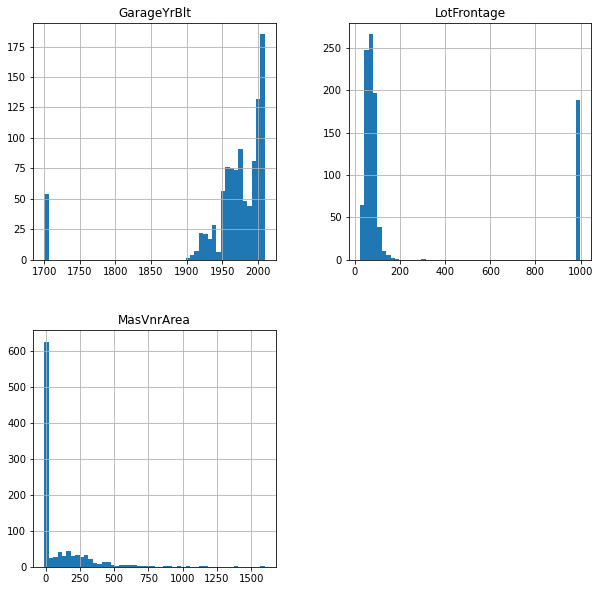

Note the bars corresponding to the arbitrary values at 1700, 999 and -1 for each feature.

# ----------

#### Feature-Engine

Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

All the predictor variables contain missing data.

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine captures the numerical variables automatically

In [ ]:
# let's do it imputation but this time
# and let's do it over 2 of the 3 numerical variables

imputer = mdi.ArbitraryNumberImputer(arbitrary_number = -999,
                                     variables=['LotFrontage', 'MasVnrArea'])

imputer.fit(X_train)

In [ ]:
# now the imputer uses only the variables we indicated

imputer.variables

In [ ]:
# and we can see the value assigned to each variable
imputer.arbitrary_number

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)

# let's check null values are gone
tmp[imputer.variables].isnull().mean()

Feature-engine can be used with the Scikit-learn pipeline

In [ ]:
# let's look at the distributions to determine the
# arbitraty values to use

X_train.hist()

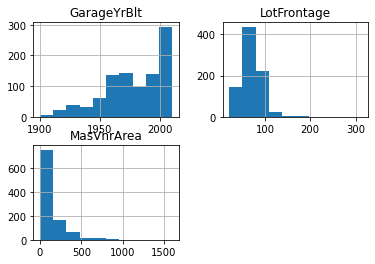

In [ ]:
pipe = Pipeline([
    ('imputer_999', mdi.ArbitraryNumberImputer(arbitrary_number = -999,
                                             variables = ['LotFrontage', 'MasVnrArea'])),
     
    ('imputer_minus1', mdi.ArbitraryNumberImputer(arbitrary_number = -1,
                                          variables = ['GarageYrBlt'])),
     ])

In [ ]:
pipe.fit(X_train)

In [ ]:
pipe.named_steps['imputer_999'].arbitrary_number

In [ ]:
pipe.named_steps['imputer_minus1'].arbitrary_number

In [ ]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

# --------------------------------------------------------------------------------------------------------------

# 2.4 END OF DISTRIBUTION IMPUTATION<a class="anchor" id="end"></a>
Determining the value of the arbitrary value can be laborious and it is usually a manual job. We can automate this process by automatically selecting arbitrary values at the end of the variable distributions.

###### How do we select the value at the end?
- If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation
- If the variable is skewed, we can use the IQR proximity rule
- We can also select the min / max value and multiply it by a certain amount of times, like 2 or 3.

###### Which variables can I impute with an arbitrary value?
This method is suitable for numerical variables.

###### Assumptions
- MNAR - values are not missing at random

###### Advantages
- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingess" if there is one

###### Disadvantages
- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- This technique may mask true outliers in the distribution

###### OPTIONS FOR END OF DISTRIBUTION IMPUTATION

###### 1. Create a function

###### 2. FeatureEngine

# ----------

###### Create a Function

In [ ]:
# let's look at the percentage of NA
data.isnull().mean()

Imputation has to be done over the training set, and then propagated to the test set. For this imputation technique, this means that when selecting the value with which we will replace the NA, we need to do so only by looking at the distribution of the variables in the training set. Then we use the selected value to replace NA both in the train and test set.

In [ ]:
# in the next list comprehension, I loop over all the columns 
# of the dataset and select those that contain missing data

[var for var in data.columns if data[var].isnull().sum()>0]

In [ ]:
# find the percentage of missing data within those variables
# same code as we learnt in section 3 on variable characteristics

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's plot the distributions of the variables
# we learnt this code in section 3 on variable characteristics

X_train[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].hist(bins=50, figsize=(10,10))
plt.show()

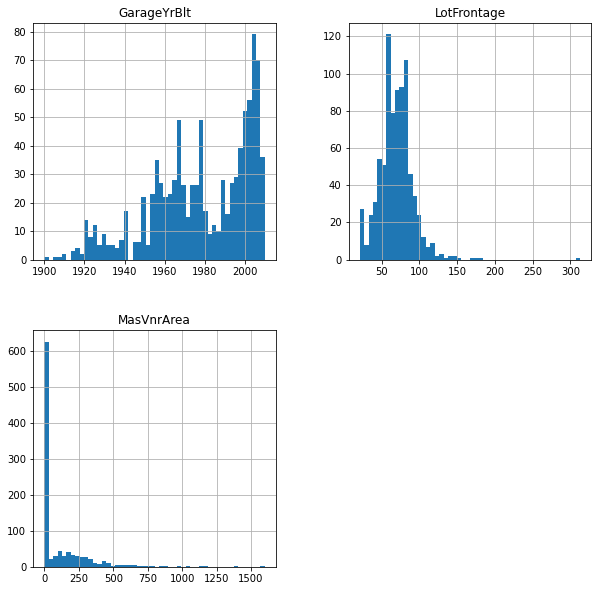

In [ ]:
# the variables are not normally distributed

# let's impute the NA using the IQR proximity rule, which we learnt
# in the lecture on outliers in section 3

# calulate the IQR
IQR = X_train['LotFrontage'].quantile(0.75) - X_train['LotFrontage'].quantile(
    0.25)

# calculate the upper boundary
extreme_value = X_train['LotFrontage'].quantile(0.75) + 3 * IQR

extreme_value

In [ ]:
# let's impute the NA with the extreme value

X_train.loc[:,'LotFrontage_imputed'] = impute_na(X_train, 'LotFrontage', extreme_value)
X_test.loc[:,'LotFrontage_imputed'] = impute_na(X_test, 'LotFrontage', extreme_value)

In [ ]:
# let's evaluate the effect of end tail imputation on the distribution

# we can see that the distribution has changed for LotFrontAge
# with now more values accumulating towards the extreme value

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# imputed variable
X_train['LotFrontage_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [ ]:
# we see that there are a fewer outliers as well after the imputation

X_train[['LotFrontage', 'LotFrontage_imputed']].boxplot()

In [ ]:
# similarly we can explore the effect of the imputation technique on 
# the variance

# we can see a change in the variance after imputation for LotFrontAge
# this is expected, because the percentage of missing data is quite
# high ~20%

print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after imputation: ', X_train['LotFrontage_imputed'].var())

Do the prior 5 steps for all variables that want to impute missing values.

In [ ]:
# finally, let's explore the covariance:
# take your time to compare the values in the table below.

X_train.cov()

# ----------

##### Feature-Engine
Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

All the predictor variables contain missing data.

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine captures the numerical variables automatically

In [ ]:
# we call the imputer from feature-engine

# we specify whether we want to find the values using
# the gaussian approximation or the inter-quantal range
# proximity rule.

# in addition we need to specify if we want the values placed at 
# the left or right tail

# let's do it over 2 of the 3 numerival variables

imputer = mdi.EndTailImputer(distribution='skewed', tail='left',
                             variables=['LotFrontage', 'MasVnrArea'])

# we fit the imputer

imputer.fit(X_train)

In [ ]:
# we see that the imputer found the numerical variables to
# impute with the end of distribution value

imputer.variables

In [ ]:
# here we can see the values that will be used
# to replace NA for each variable

imputer.imputer_dict_

In [ ]:
# and this is how those values were calculated
# which is how we learnt in the first notebooks of
# this section

X_train[imputer.variables].mean() + 3 * X_train[imputer.variables].std()

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables].isnull().mean()

# ----------

###### Feature-engine can be used with the Scikit-learn pipeline

In [ ]:
# let's look at the distributions to determine the
# end tail value selection method

X_train.hist()

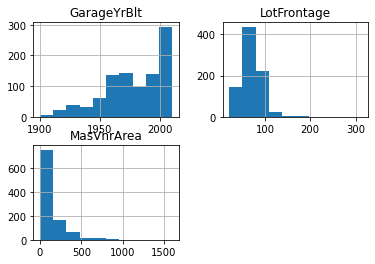

In [ ]:
pipe = Pipeline([
    ('imputer_skewed', mdi.EndTailImputer(distribution='skewed', tail='right',
                                          variables=['GarageYrBlt', 'MasVnrArea'])),

    ('imputer_gaussian', mdi.EndTailImputer(distribution='gaussian', tail='right',
                                            variables=['LotFrontage'])),
])

In [ ]:
pipe.fit(X_train)

In [ ]:
pipe.named_steps['imputer_skewed'].imputer_dict_

In [ ]:
pipe.named_steps['imputer_gaussian'].imputer_dict_

In [ ]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

# --------------------------------------------------------------------------------------------------------------

# 2.5 FREQUENT CATEGORY IMPUTATION<a class="anchor" id="frequent"></a>


Mode imputation consists of replacing all occurrences of missing values (NA) within a variable by the mode, which in other words refers to the **most frequent value** or **most frequent category**.


###### Which variables can I impute with most frequent / mode Imputation?

Although the mode, or most frequent value can be calculated for both numerical and categorical variables, in practice, we only use this technique on categorical variables. The reason is that for numerical variables, the mean or the median tend to better represent the average value of the population.

###### Assumptions
- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mode)
- No more than 5% of the variable contains missing data

The rationale is that the value that should have been seen for the missing observation is most likely the most frequent value or category of the variable.


###### Advantages
- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)


###### Limitations
- Distortion the relation of the most frequent label with other variables within the dataset
- May lead to an over-representation of the most frequent label if there is a big number of NA

###### OPTIONS FOR FREQUENT CATEGORY IMPUTATION

###### 1. Create a function

###### 2. SimpleImputer on entire dataset
    Advantages
        - Simple to use if applied to the entire dataframe
        - Maintained by the scikit-learn developers: good quality code
        - Fast computation (it uses numpy for calculations)
        - Allows for grid search over the various imputation techniques
        - Allows for different missing values encodings (you can indicate if the missing values are np.nan, or zeroes, etc)

    Limitations
        - Returns a numpy array instead of a pandas dataframe, inconvenient for data analysis
        - Needs to use additional classes to select which features to impute  ==>
            - requires more lines of code
            - additional classes still in beta (may change without warning)
            - not so straightforward to use anymore.
            
###### 3. SimpleImputer: different procedures on different features

###### 4. FeatureEngine


# ----------

##### Create a Function

In [ ]:
# let's inspect the percentage of missing values in each variable

data.isnull().mean()

In [ ]:
BsmtQual       0.025342
FireplaceQu    0.472603
SalePrice      0.000000
dtype: float64

The variable BsmtQual contains only a few observations with NA (2.5), therefore, replacing those observations with the value of the most frequent category is a good approach.

On the other hand, the variable FireplaceQu, contains missing data in almost half of the observations. Therefore, replacing those with the most frequent category is most likely going to distort the relationship of the most frequent category with the sale price.

Imputation should be done over the training set, and then propagated to the test set. This means that the most frequent category has to be selected from the training set, and used to replace NA both in train and test sets.

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['SalePrice'], # target
    test_size=0.3, # percentage of observations in the test set
    random_state=0) # seed for reproducibility

X_train.shape, X_test.shape

In [ ]:
# let's remind ourselves of the % of missing values
X_train['BsmtQual'].isnull().mean()

In [ ]:
# let's inspect the number of observations per category in BsmtQual

# we used this line of code in section 3 on variable characteristics

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses')

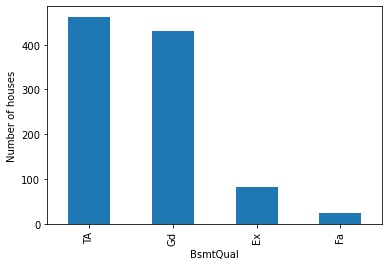

In [ ]:
# Let's find the most frequent category for BsmtQual

X_train['BsmtQual'].mode()

In [ ]:
# let's plot the distribution of the target for the houses that:

# * show the most frequent category or
# * those that show missing data

fig = plt.figure()
ax = fig.add_subplot(111)

# select and plot houses with the most frequent label
X_train[X_train['BsmtQual']=='TA']['SalePrice'].plot(kind='kde', ax=ax)

# select and plot houses with missing data in the variable
X_train[X_train['BsmtQual'].isnull()]['SalePrice'].plot(kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Houses with TA', 'Houses with NA']
ax.legend(lines, labels, loc='best')

# add figure title
plt.title('BsmtQual')

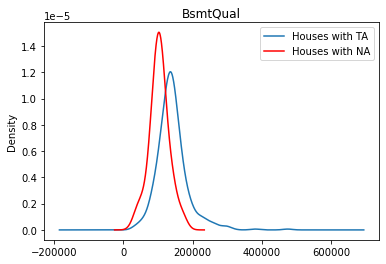

The plot above indicates that the houses with missing data cost overall less than those with the label TA. Therefore, replacing missing values by TA, could affect the overall distribution, if there were a lot of NA.

In [ ]:
# I keep the original distribution of SalePrice for the most
# frequent category for later

# the use of tmp is common to name temporal variables

tmp = X_train[X_train['BsmtQual']=='TA']['SalePrice']

In [ ]:
# Let's fill na in both train and test

# I use the fillna() method from pandas

# with the argument inplace=True, I indicate to pandas
# that I want the values replaced in the same dataset

X_train['BsmtQual'].fillna('TA', inplace=True)
X_test['BsmtQual'].fillna('TA', inplace=True)

In [ ]:
# check that NA have been filled

X_train['BsmtQual'].isnull().sum()

In [ ]:
# evaluate effect on distribution of categories

X_train['BsmtQual'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('BsmtQual')
plt.ylabel('Number of houses')

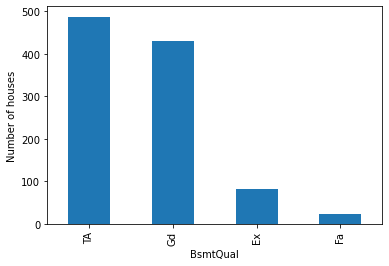

From the above plot, we see that now there are a few more houses with the label TA, which are those that before contained NA, but the overall effect on the distribution is not dramatic. The plot looks almost identical to that one before the imputation.

In [ ]:
# did the distribution of SalePrice for the most frequent category change?
# let's have a look

fig = plt.figure()
ax = fig.add_subplot(111)

# original distribution of salePrice for houses with most frequent label
# remember I captured this a few cells up in the notebook
tmp.plot(kind='kde', ax=ax)

# distribution of the variable after imputation
X_train[X_train['BsmtQual'] == 'TA']['SalePrice'].plot(
    kind='kde', ax=ax, color='red')

# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

# add title
plt.title('BsmtQual')

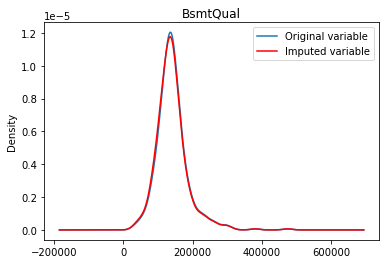

The distribution of house prices between the original and imputed variable is quite similar, because the number of missing data was small. We expected this behaviour.

# ----------

##### SimpleImputer

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# these are the objects we need to impute missing data
# with sklearn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# to split the datasets
from sklearn.model_selection import train_test_split

In [ ]:
# we use only the following variables for the demo:
# a mix of categorical and numerical

cols_to_use = ['BsmtQual', 'FireplaceQu', 'MSZoning',
               'BsmtUnfSF', 'LotFrontage', 'MasVnrArea',
               'Street', 'Alley', 'SalePrice']

In [ ]:
# let's load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

In [ ]:
# let's check the null values
data.isnull().mean()

The cateogrical variables Alley, BsmtQual and FirePlaceQu contain missing data.

In [ ]:
# let's separate into training and testing set

# first let's remove the target from the features
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use], # just the features
                                                    data['SalePrice'], # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=0) # for reproducibility
X_train.shape, X_test.shape

In [ ]:
# let's check the misssing data again
X_train.isnull().mean()

SimpleImputer on the entire dataset

In [ ]:
# Now we impute the missing values with SimpleImputer

# create an instance of the simple imputer
# we indicate that we want to impute with the 
# most frequent category

imputer = SimpleImputer(strategy='most_frequent')

# we fit the imputer to the train set
# the imputer will learn the mode of ALL variables
# categorical or not
imputer.fit(X_train[cols_to_use])

In [ ]:
# we can look at the learnt frequent values like this:
imputer.statistics_

In [ ]:
array(['TA', 'Gd', 'RL', 0, 60.0, 0.0, 'Pave', 'Pave'], dtype=object)

**Note** that the transformer learns the most frequent value for both categorical AND numerical variables.

In [ ]:
# and we can investigate the frequent values to corroborate
# the imputer did a good job
X_train[cols_to_use].mode()

In [ ]:
# and now we impute the train and test set

# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train

In [ ]:
# encode the train set back to a dataframe:

pd.DataFrame(X_train, columns=cols_to_use).head()

# ----------

###### SimpleImputer: different procedures on different features

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's look at the missing values
X_train.isnull().mean()

For this demo, I will impute:

- categorical variables with the frequent category
- numerical variables with the mean.

In [ ]:
# first we need to make lists, indicating which features
# will be imputed with each method

features_numeric = ['BsmtUnfSF', 'LotFrontage', 'MasVnrArea', ]
features_categoric = ['BsmtQual', 'FireplaceQu', 'MSZoning',
                      'Street', 'Alley']

# then we instantiate the imputers, within a pipeline
# we create one mean imputer and one frequent category imputer
# by changing the parameter in the strategy

numeric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

categoric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
])

# then we put the features list and the transformers together
# using the column transformer

preprocessor = ColumnTransformer(transformers=[
    ('numeric_imputer', numeric_imputer, features_numeric),
    ('categoric_imputer', categoric_imputer, features_categoric)
])

In [ ]:
# now we fit the preprocessor
preprocessor.fit(X_train)

In [ ]:
# we can explore the transformers like this:

preprocessor.transformers

In [ ]:
# and we can look at the parameters learnt like this:

# for the mean imputer
preprocessor.named_transformers_['numeric_imputer'].named_steps['imputer'].statistics_

In [ ]:
# and we can corroborate the value with that one in
# the train set
X_train[features_numeric].mean()

In [ ]:
# for frequent category imputer

preprocessor.named_transformers_['categoric_imputer'].named_steps['imputer'].statistics_

In [ ]:
# and we corroborate those values in the train set

X_train[features_categoric].mode()

   BsmtQual	FireplaceQu	MSZoning	Street	Alley
0	TA	     Gd	        RL	        Pave	 Pave

In [ ]:
X_train.shape

In [ ]:
# see how the result of the imputation is a 3 column dataset
pd.DataFrame(X_train,
             columns=features_numeric + features_categoric).head()

    BsmtUnfSF	LotFrontage	MasVnrArea	BsmtQual	FireplaceQu	MSZoning	Street	Alley
0	318	         69.6687	573	        Gd	         Gd       	RL	        Pave	Pave


# ----------

##### Feature-Engine

Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

All the predictor variables contain missing data.

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine captures the categorical variables automatically

In [ ]:
# let's do it imputation but this time
# and let's do it over 1 of the 2 categorical variables

imputer = mdi.CategoricalVariableImputer(
    imputation_method='frequent', variables=['BsmtQual'])

In [ ]:
# we fit the imputer

imputer.fit(X_train)

In [ ]:
# we see that the imputer found the categorical variables to
# impute with the frequent category

imputer.variables

In [ ]:
# here we can see the values that will be used
# to replace NA for each variable

imputer.imputer_dict_

In [ ]:
# let's check those values agains the train data

X_train[imputer.variables].mode()

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables].isnull().mean()

# --------------------------------------------------------------------------------------------------------------

# 2.6 MISSING CATEGORY IMPUTATION<a class="anchor" id="misscat"></a>

This is the most widely used method of missing data imputation for categorical variables. This method consists in treating missing data as an additional label or category of the variable. All the missing observations are grouped in the newly created label 'Missing'.

This is in essence, the equivalent of replacing by an arbitrary value for numerical variables.

The beauty of this technique resides on the fact that it does not assume anything about the fact that the data is missing. It is very well suited when the number of missing data is high.


###### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingness" if there is one
- No assumption made on the data


###### Limitations

- If the number of NA is small, creating an additional category may cause trees to over-fit

###### OPTIONS FOR MISSING CATEGORY IMPUTATION

###### 1. Create a function

###### 2. SimpleImputer
    Advantages
    - Simple to use if applied to the entire dataframe
    - Maintained by the scikit-learn developers: good quality code
    - Fast computation (it uses numpy for calculations)
    - Allows for grid search over the various imputation techniques
    - Allows for different missing values encodings (you can indicate if the missing values are np.nan, or zeroes, etc)

    Limitations
    - Returns a numpy array instead of a pandas dataframe, inconvenient for data analysis
    - Needs to use additional classes to select which features to impute  ==>
        - requires more lines of code
        - additional classes still in beta (may change without warning)
        - not so straightforward to use anymore.
        
###### 3. FeatureEngine


# ----------

##### Create a Function

In [ ]:
# let's inspect the percentage of missing values in each variable

data.isnull().mean()

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data,
    data.SalePrice,
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

In [ ]:
# let's remind ourselves of the % of missing values
X_train['FireplaceQu'].isnull().mean()

In [ ]:
# let's inspect the number of observations per category

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses')

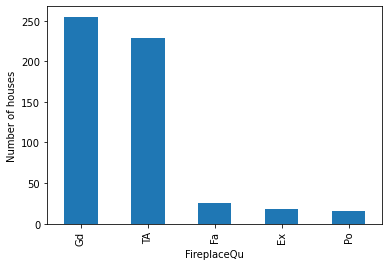

In [ ]:
# Let's fill na in both train and test

X_train['FireplaceQu'].fillna('Missing', inplace=True)
X_test['FireplaceQu'].fillna('Missing', inplace=True)

In [ ]:
# let's inspect the number of observations per category
# in the imputed variable

X_train['FireplaceQu'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('FireplaceQu')
plt.ylabel('Number of houses')

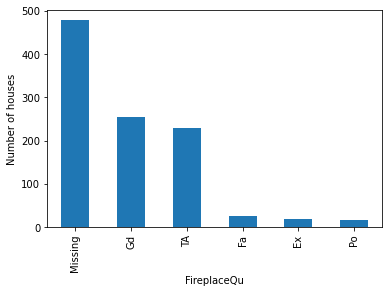

We see now the additional category with the missing data: Missing

This label contains most of the houses, as most showed missing data originally.

In [ ]:
# let's plot the distribution of the target for the houses
# that show the different categories of the variable

fig = plt.figure()
ax = fig.add_subplot(111)

# a plot per category
X_train[X_train['FireplaceQu']=='Missing']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train['FireplaceQu']=='Gd']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train['FireplaceQu']=='TA']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train['FireplaceQu']=='Fa']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train['FireplaceQu']=='Ex']['SalePrice'].plot(kind='kde', ax=ax)
X_train[X_train['FireplaceQu']=='Po']['SalePrice'].plot(kind='kde', ax=ax)


# add the legend
lines, labels = ax.get_legend_handles_labels()
labels = ['Missing','Gd', 'TA', 'Fa', 'Ex', 'Po']
ax.legend(lines, labels, loc='best')

We observe again that the houses with different labels for FirePlaceQu also show different distributions of SalePrice, with those showing Ex being the most expensive ones and those showing Missing, or Fa being the cheapest ones.


In [ ]:
# BONUS: in case you need the plot for your analysis:
# here is a way of making it more general


def automate_plot(df, variable, target):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for category in df[variable].unique():
        df[df[variable]==category][target].plot(kind='kde', ax=ax)
    
    # add the legend
    lines, labels = ax.get_legend_handles_labels()
    labels = df[variable].unique()
    ax.legend(lines, labels, loc='best')
    
    plt.show()

In [ ]:
automate_plot(X_train, 'FireplaceQu', 'SalePrice')

# ----------

##### SimpleImputer

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# these are the objects we need to impute missing data
# with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the datasets
from sklearn.model_selection import train_test_split

In [ ]:
# let's load the dataset with a few categorical columns

# these are categorical columns and the target SalePrice
cols_to_use = ['BsmtQual', 'FireplaceQu', 'SalePrice']

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
# let's inspect the percentage of missing values in each variable

data.isnull().mean()

The variables LotFrontage, MasVnrArea and GarageYrBlt contain missing data.

In [ ]:
# let's separate into training and testing set

# first let's remove the target from the features
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(
    data[cols_to_use],  # just the features
    data['SalePrice'],  # the target
    test_size=0.3,  # the percentage of obs in the test set
    random_state=0)  # for reproducibility

X_train.shape, X_test.shape

In [ ]:
# let's check the misssing data again
X_train.isnull().mean()

In [ ]:
# let's inspect the values of the categorical variable
X_train['BsmtQual'].unique()

In [ ]:
# let's inspect the values of the categorical variable
X_train['FireplaceQu'].unique()

In [ ]:
# Now we impute the missing values with SimpleImputer

# create an instance of the simple imputer
# we indicate that we want to impute by replacing NA
# with 'Missing'

imputer = SimpleImputer(strategy='constant', 
                       fill_value = 'Missing')

# we fit the imputer to the train set
# the imputer will learn the median of all variables
imputer.fit(X_train)

In [ ]:
# we can look at the learnt modes like this:
imputer.statistics_

In [ ]:
# and now we impute the train and test set

# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train

In [ ]:
# encode the train set back to a dataframe:

X_train = pd.DataFrame(X_train, columns=cols_to_use)
X_train.head()

In [ ]:
X_train['BsmtQual'].unique()

In [ ]:
X_train.isnull().mean()

**A MASSIVE NOTE OF CAUTION**:

Note that when using SimpleImputer and setting the parameters to:
- strategy='constant'
- fill_value = 'Missing'

If your dataframe contains variables that are numerical and categorical, NA in both will be replaced by 'Missing" therefore converting your numerical variables into categorical, which is probably not what you are after.

Most datasets contain both numerical and categorical variables, so very likely you will have to use a column transformer

In [ ]:
# let's load the dataset with both numerical and categorical variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's look at the missing values

X_train.isnull().mean()

For this demo, I will impute the numerical variables by the mean, and the categorical variables by the most frequent category.

In [ ]:
# first we need to make lists, indicating which features
# will be imputed with each method

features_numeric = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
features_categoric = ['BsmtQual', 'FireplaceQu']

# then we instantiate the imputers, within a pipeline
# we create one imputer for numerical and one imputer
# for categorical

imputer_numeric = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

imputer_categoric = Pipeline(
    steps=[('imputer',
            SimpleImputer(strategy='constant', fill_value='Missing'))])

# then we put the features list and the transformers together
# using the column transformer

preprocessor = ColumnTransformer(transformers=[('imputer_numeric',
                                                imputer_numeric,
                                                features_numeric),
                                               ('imputer_categoric',
                                                imputer_categoric,
                                                features_categoric)])

In [ ]:
# now we fit the preprocessor
preprocessor.fit(X_train)

In [ ]:
# we can explore the transformers like this:
preprocessor.transformers

In [ ]:
# and we can look at the parameters learnt like this:

# for the numerical imputer
preprocessor.named_transformers_['imputer_numeric'].named_steps['imputer'].statistics_

In [ ]:
# for the categorical imputer
preprocessor.named_transformers_['imputer_categoric'].named_steps['imputer'].statistics_

In [ ]:
# and now we can impute the data
# remember it returs a numpy array

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
# now we convert the result into a dataframe
pd.DataFrame(X_train,
             columns=features_numeric+features_categoric).head()

In [ ]:
# now we convert the result into a dataframe
# and explore the missing values
# there should be none

X_train = pd.DataFrame(X_train,
             columns=features_numeric+features_categoric)

X_train.isnull().mean()

LotFrontage    0.0
MasVnrArea     0.0
GarageYrBlt    0.0
BsmtQual       0.0
FireplaceQu    0.0
dtype: float64

# ----------

##### Feature-Engine
Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine captures the categorical variables automatically

In [ ]:
# and let's do it over 1 of the 2 categorical variables

imputer = mdi.CategoricalVariableImputer(variables=['BsmtQual'])

imputer.fit(X_train)

In [ ]:
# we see that the imputer found the categorical variables to
# impute with the frequent category

imputer.variables

This imputer will replace missing data in categorical variables by 'Missing'

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check that the numerical variables don't
# contain NA any more

tmp[imputer.variables].isnull().mean()

Feature-engine can be used with the Scikit-learn pipeline

In [ ]:
# let's check the percentage of NA in each categorical variable

X_train.isnull().mean()

In [ ]:
pipe = Pipeline([
    ('imputer_mode', mdi.CategoricalVariableImputer(imputation_method='frequent', variables=['BsmtQual'])),
    ('imputer_missing', mdi.CategoricalVariableImputer(variables=['FireplaceQu'])),
])

In [ ]:
pipe.fit(X_train)

In [ ]:
pipe.named_steps['imputer_mode'].variables

In [ ]:
pipe.named_steps['imputer_missing'].variables

In [ ]:
# let's transform the data with the pipeline
tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

# --------------------------------------------------------------------------------------------------------------

# 2.7 RANDOM SAMPLE IMPUTATION<a class="anchor" id="random"></a>

Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

By random sampling observations of the variable for those instances where data is available, we guarantee that the mean and standard deviation of the variable are preserved.

By random sampling observations of the present categories, for categorical variables, we guarantee that the frequency of the different categories / labels within the variable is preserved.


###### Which variables can I impute by Random Sample Imputation?

Random Sample Imputation can be applied to both numerical and categorical variables.


###### Assumptions

Random sample imputation assumes that the data are missing completely at random (MCAR). If this is the case, it makes sense to substitute the missing values by values extracted from the original variable distribution. 

From a probabilistic point of view, values that are more frequent, like the mean or the median or the most frequent category, for categorical variables, will be selected more often -because there are more of them to select from-, but other less frequent values will be selected as well. Thus, the variance and distribution of the variable are preserved. 

The idea is to replace the population of missing values with a population of values with the same distribution of the original variable.


##### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Preserves the variance of the variable

##### Limitations

- Randomness
- The relationship of imputed variables with other variables may be affected if there are a lot of NA
- Memory heavy for deployment, as we need to store the original training set to extract values from and replace the NA in coming observations.


###### When to use Random Sample Imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data
- Well suited for linear models as it does not distort the distribution, regardless of the % of NA

If used in combination with a Missing Indicator, then this method can be used when data is not missing at random as well, or when there are many missing observations.


###### Randomness

Randomness may not seem much of a concern when replacing missing values for data competitions, where the whole batch of missing values is replaced once and then the dataset is scored and that is the end of the problem. However, in business scenarios the situation is very different. 

Imagine for example a car manufacturer is trying to predict how long a certain car will be in the garage before it passes all the security tests. Today, they receive a car with missing data in some of the variables, they run the machine learning model to predict how long this car will stay in the garage, the model replaces missing values by a random sample of the variable and then produces an estimate of time. Tomorrow, when they run the same model on the same car, the model will randomly assign values to the missing data, that may or may not be the same as the ones it selected today, therefore, the final estimation of time in the garage, may or may not be the same as the one obtained the day before.

In addition, imagine the car manufacturer evaluates 2 different cars that have exactly the same values for all of the variables, and missing values in exactly the same subset of variables. They run the machine learning model for each car, and because the missing data is randomly filled with values, the 2 cars, that are exactly the same, may end up with different estimates of time in the garage.

This may sound completely trivial and unimportant, however, businesses must follow a variety of regulations, and some of them require the same treatment to be provided to the same situation. So if instead of cars, these were people applying for a loan, or people seeking for disease treatment, the machine learning model would end up providing different solutions to candidates that are otherwise in the same conditions. And this is not fair or acceptable. This behaviour needs to be avoided.

###### So, should we randomly replace NA or not?

It is still possible to replace missing data by random sample, but these randomness needs to be controlled, so that individuals in the same situation end up with the same scores and therefore with the same solutions offered. How can we ensure this? by appropriately setting seeds during the random extraction of values.

Finally, another potential limitation of random sampling, similarly to replacing with the mean and median, is that estimates of covariance and correlations with other variables in the dataset may also be washed off by the randomness, particularly if there are a lot of missing observations.


###### Final note

Replacement of missing values by random sample, although similar in concept to replacement by the median or mean, is not as widely used in the data science community as the mean / median imputation, presumably because of the element of randomness, or because the code implementation is not so straightforward.

However, it is a valid approach, with clear advantages over mean / median imputation as it preserves the distribution of the variable. And if you are mindful of the element of randomness and account for it somehow, this may as well be your method of choice, particularly for linear models.


###### OPTIONS FOR RANDOM SAMPLE IMPUTATION

###### 1. Create a function

###### 2. FeatureEngine

# ----------

###### Create Function

In [ ]:
# let's look at the percentage of NA

data.isnull().mean()

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data.survived,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

In [ ]:
# let's impute Age by random sampling both in
# train and test sets

# create the new variable where NA will be imputed:
# make a copy from the original variable, with NA
X_train['Age_imputed'] = X_train['age'].copy()
X_test['Age_imputed'] = X_test['age'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = X_train['age'].dropna().sample(
    X_train['age'].isnull().sum(), random_state=0)

random_sample_test = X_train['age'].dropna().sample(
    X_test['age'].isnull().sum(), random_state=0)

# what is all of the above code doing?

# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['Age'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train['age'].isnull()].index
random_sample_test.index = X_test[X_test['age'].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train['age'].isnull(), 'Age_imputed'] = random_sample_train
X_test.loc[X_test['age'].isnull(), 'Age_imputed'] = random_sample_test

In [ ]:
# check that NA were imputed
X_train['Age_imputed'].isnull().sum()

In [ ]:
X_train.head(15)

In [ ]:
# we can see that the distribution of the variable after
# random sample imputation is almost exactly the same as the original

fig = plt.figure()
ax = fig.add_subplot(111)

X_train['age'].plot(kind='kde', ax=ax)
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

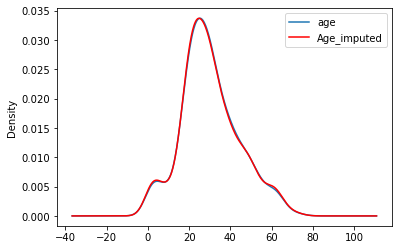

We can see that replacing missing values with a random sample from the training set preserves the original distribution of the variable. If you remember from previous notebooks, every other imputation technique altered the distribution of Age, because the percentage of NA in Age is high, ~20%. However, random sample imputation preserves the distribution, even in those cases. So this imputation technique is quite handy, if we are building linear models and we don't want to distort normal distributions.

In [ ]:
# there is some change in the variance of the variable.
# however this change is much smaller compared to mean / median
# imputation (check the previous notebook for comparison)

print('Original variable variance: ', X_train['age'].var())
print('Variance after random imputation: ', X_train['Age_imputed'].var())

In [ ]:
# the covariance of Age with Fare is also less affected by this
# imputation technique compared to mean / median imputation

X_train[['fare', 'age', 'Age_imputed']].cov()

In [ ]:
# Finally, the outliers are also less affected by this imputation
# technique

# Let's find out using a boxplot
X_train[['age', 'Age_imputed']].boxplot()

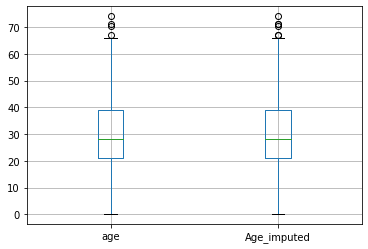

So random sample imputation offers all the advantages provided by the preservation of the original distribution. And that is a big plus, particularly, if we care about distribution and outliers for our machine learning models. This is particularly relevant for linear models. But not so important for tree based algorithms.

Randomness can lead to different scores being assigned to the same observation

###### How can we fix this behaviour?

We can fix this randomness by assigning a seed.

However, if we set the same seed for every single observation, what would happen is that for every different observation, we would be filling the NA with exactly the same value (same seed == same random value extracted). This would be the equivalent to arbitrary value imputation!!!

We don't want that behaviour either.

Therefore, we want our seed to change observation per observation, but in a controlled manner, so that 2 observations that are exactly the same, receive the same imputed random values. But 2 observations that are different, receive different imputed random values.

In [ ]:
# we assign the Fare as the seed in the random sample extraction
sampled_value = X_train.age.dropna().sample(1,
                                            random_state=int(observation.fare))
sampled_value.index = [15]

observation['Age_random'] = sampled_value
observation

In real life, you will build models that use tens of variables or more. So in cases like those, you can think of picking the 3-5 more important variables, those that have the strongest impact on the output of the machine learning model, and combine them to create the random state. Therefore, customers that share the 3-5 main variable values, will get the same scores.

###### Random Sampling for Categorical Variables

In [ ]:
# let's impute FireplaceQu by random sampling both in
# train and test sets

# create the new variable where NA will be imputed
# make a copy from the original variable, with NA
X_train['FireplaceQu_imputed'] = X_train['FireplaceQu'].copy()
X_test['FireplaceQu_imputed'] = X_test['FireplaceQu'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = X_train['FireplaceQu'].dropna().sample(
    X_train['FireplaceQu'].isnull().sum(), random_state=0)

random_sample_test = X_train['FireplaceQu'].dropna().sample(
    X_test['FireplaceQu'].isnull().sum(), random_state=0)

# what is all of the above code doing?
# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['FireplaceQu'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train['FireplaceQu'].isnull()].index
random_sample_test.index = X_test[X_test['FireplaceQu'].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train['FireplaceQu'].isnull(), 'FireplaceQu_imputed'] = random_sample_train
X_test.loc[X_test['FireplaceQu'].isnull(), 'FireplaceQu_imputed'] = random_sample_test

In [ ]:
# check that nulls were removed
X_train['FireplaceQu_imputed'].isnull().sum()

In [ ]:
# and now let's evaluate the effect of the imputation on the distribution
# of the categories and the target within those categories

# we used a similar function in the notebook of arbitrary value imputation
# for categorical variables

def categorical_distribution(df, variable_original, variable_imputed):

    tmp = pd.concat(
        [
            # percentage of observations per category, original variable
            df[variable_original].value_counts() / len(df[variable_original].dropna()),

            # percentage of observations per category, imputed variable
            df[variable_imputed].value_counts() / len(df)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'imputed']

    return tmp

In [ ]:
# run the function in a categorical variable
categorical_distribution(X_train, 'FireplaceQu', 'FireplaceQu_imputed')

In [ ]:
# now let's look at the distribution of the target within each
# variable category

def automate_plot(df, variable, target):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for category in df[variable].dropna().unique():
        df[df[variable]==category][target].plot(kind='kde', ax=ax)
    
    # add the legend
    lines, labels = ax.get_legend_handles_labels()
    labels = df[variable].dropna().unique()
    ax.legend(lines, labels, loc='best')
    
    plt.show()

In [ ]:
automate_plot(X_train, 'BsmtQual', 'SalePrice')

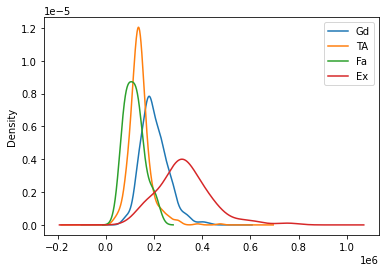

In [ ]:
automate_plot(X_train, 'BsmtQual_imputed', 'SalePrice')

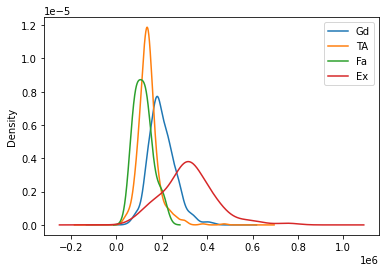

# ----------

##### Feature-Engine
Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine Random Sampler captures all the variables by default

In [ ]:
# we call the imputer from feature-engine
# we don't need to specify anything 

imputer = mdi.RandomSampleImputer(random_state = 29)

In [ ]:
# we fit the imputer

imputer.fit(X_train)

In [ ]:
# we see that the imputer selected all the variables numerical
# and categorical

imputer.variables

In [ ]:
# the imputer stores a copy of the selected variables from
# the train set, from which to extract the random sample

imputer.X_.head()

In [ ]:
# feature-engine returns a dataframe

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check absence of NA

tmp[imputer.variables].isnull().mean()

**Note** at the moment, feature-engine RandomSampleImputer does not support setting the seed.

The procedures to select a specific group of variables to use the RandomSampleImputer, or how to integrate it with the Scikit-learn pipeline are the same as we did in previous notebooks.

For details on how to set the seed observation per observation, visit an example notebook in the repository or the documentation:

https://github.com/solegalli/feature_engine/blob/master/examples/missing-data-imputers.ipynb

https://feature-engine.readthedocs.io/en/latest/imputers/RandomSampleImputer.html

# --------------------------------------------------------------------------------------------------------------

# 2.8 MISSING INDICATOR<a class="anchor" id="missind"></a>

###### Adding a variable to capture NA

There are other methods that can be used when values are not missing at random, for example arbitrary value imputation or end of distribution imputation. However, these imputation techniques will affect the variable distribution dramatically, and are therefore not suitable for linear models.

If data are not missing at random, it is a good idea to replace missing observations by the mean / median / mode AND  **flag** those missing observations as well with a **Missing Indicator**. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).


###### For which variables can I add a missing indicator?

We can add a missing indicator to both numerical and categorical variables. 

###### Note

Adding a missing indicator is never used alone. On the contrary, it is always used together with another imputation technique, which can be mean / median imputation for numerical variables, or frequent category imputation for categorical variables. We can also use random sample imputation together with adding a missing indicator for both categorical and numerical variables.

Commonly used together:

- Mean / median imputation + missing indicator (Numerical variables)
- Frequent category imputation + missing indicator (Categorical variables)
- Random sample Imputation + missing indicator (Numerical and categorical)

###### Assumptions

- Data is not missing at random
- Missing data are predictive

###### Advantages

- Easy to implement
- Captures the importance of missing data if there is one

###### Limitations

- Expands the feature space
- Original variable still needs to be imputed to remove the NaN

Adding a missing indicator will increase 1 variable per variable in the dataset with missing values. So if the dataset contains 10 features, and all of them have missing values, after adding a missing indicator we will have a dataset with 20 features: the original 10 features plus additional 10 binary features, which indicate for each of the original variables whether the value was missing or not. This may not be a problem in datasets with tens to a few hundreds variables, but if our original dataset contains thousands of variables, by creating an additional variable to indicate NA, we will end up with very big datasets. 

###### Important

In addition, data tends to be missing for the same observation across multiple variables, which often leads to many of the missing indicator variables to be actually similar or identical to each other.

###### OPTIONS FOR MISSING INDICATOR IMPUTATION

###### 1. Create a function

###### 2. Scikit-learn

###### 3. SimpleImputer

###### 4. FeatureEngine

# ----------

In [ ]:
# let's look at the percentage of NA

data.isnull().mean()

To add a binary missing indicator, we don't necessarily need to learn anything from the training set, so in principle we could do this in the original dataset and then separate into train and test. However, I do not recommend this practice.
In addition, if you are using scikit-learn to add the missing indicator, the indicator as it is designed, needs to learn from the train set, which features to impute, this is, which are the features for which the binary variable needs to be added.

In [ ]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

In [ ]:
# Let's explore the missing data in the train set
# the percentages should be fairly similar to those
# of the whole dataset

X_train.isnull().mean()

In [ ]:
# add the missing indicator

# this is done very simply by using np.where from numpy
# and isnull from pandas:

X_train['Age_NA'] = np.where(X_train['age'].isnull(), 1, 0)
X_test['Age_NA'] = np.where(X_test['age'].isnull(), 1, 0)

X_train.head()

In [ ]:
# the mean of the binary variable, coincides with the 
# perentage of missing values in the original variable

X_train['Age_NA'].mean()

In [ ]:
# yet the original variable, still shows the missing values
# which need to be replaced by any of the techniques
# we have learnt

X_train.isnull().mean()

In [ ]:
# for example median imputation

median = X_train['age'].median()

X_train['age'] = X_train['age'].fillna(median)
X_test['age'] = X_test['age'].fillna(median)

# check that there are no more missing values
X_train.isnull().mean()

Other method:

In [ ]:
# let's make a function to add a missing indicator
# binary variable

def missing_indicator(df, variable):    
    return np.where(df[variable].isnull(), 1, 0)

In [ ]:
# let's loop over all the variables and add a binary 
# missing indicator with the function we created

for variable in cols_to_use:
    X_train[variable+'_NA'] = missing_indicator(X_train, variable)
    X_test[variable+'_NA'] = missing_indicator(X_test, variable)
    
X_train.head()

In [ ]:
# now let's evaluate the mean value of the missing indicators

# first I capture the missing indicator variables with a 
# list comprehension
missing_ind = [col for col in X_train.columns if 'NA' in col]

# calculate the mean
X_train[missing_ind].mean()

In [ ]:
# the mean of the missing indicator
# coincides with the percentage of missing values
# in the original variable

X_train.isnull().mean()

Other method:

In [ ]:
# let's make a function to fill missing values with a value:
# we have use a similar function in our previous notebooks
# so you are probably familiar with it

def impute_na(df, variable, value):
    return df[variable].fillna(value)

In [ ]:
# let's impute the NA with  the median for numerical
# variables
# remember that we calculate the median using the train set

median = X_train['LotFrontage'].median()
X_train['LotFrontage'] = impute_na(X_train, 'LotFrontage', median)
X_test['LotFrontage'] = impute_na(X_test, 'LotFrontage', median)

median = X_train['MasVnrArea'].median()
X_train['MasVnrArea'] = impute_na(X_train, 'MasVnrArea', median)
X_test['MasVnrArea'] = impute_na(X_test, 'MasVnrArea', median)


# let's impute the NA in categorical variables by the 
# most frequent category (aka the mode)
# the mode needs to be learnt from the train set

mode = X_train['BsmtQual'].mode()[0]
X_train['BsmtQual'] = impute_na(X_train, 'BsmtQual', mode)
X_test['BsmtQual'] = impute_na(X_test, 'BsmtQual', mode)

mode = X_train['FireplaceQu'].mode()[0]
X_train['FireplaceQu'] = impute_na(X_train, 'FireplaceQu', mode)
X_test['FireplaceQu'] = impute_na(X_test, 'FireplaceQu', mode)

In [ ]:
# and now let's check there are no more NA
X_train.isnull().mean()

# ----------

###### Scikit-learn

Scikit-learn provides the **MissingIndicator** class to add a binary variable that flags NA.

The MissingIndicator has the option of adding a Missing indicator binary variable to all the variables in the dataset, or only those that show NA in the train set.

###### Attention!

The transformer only returns the binary variables, which need to be added to the original train data.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# these are the objects we need to impute missing data
# with sklearn
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline

# to split the datasets
from sklearn.model_selection import train_test_split

In [ ]:
# we use only the following variables for the demo:
# a mix of categorical and numerical

cols_to_use = ['BsmtQual', 'FireplaceQu', 'MSZoning',
               'BsmtUnfSF', 'LotFrontage', 'MasVnrArea',
               'Street', 'Alley', 'SalePrice']

In [ ]:
# let's load the House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

In [ ]:
# let's check the null values
data.isnull().mean()

In [ ]:
# let's separate into training and testing set

# first let's remove the target from the features
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use], # just the features
                                                    data['SalePrice'], # the target
                                                    test_size=0.3, # the percentage of obs in the test set
                                                    random_state=0) # for reproducibility
X_train.shape, X_test.shape

In [ ]:
# let's check the misssing data again
X_train.isnull().mean()

In [ ]:
# add missing indicator
indicator = MissingIndicator(error_on_new=True, features='missing-only')
indicator.fit(X_train) 

In [ ]:
# we can see the features with na:
# the result shows the index

indicator.features_

In [ ]:
# we can find the feature names by passing the index to the
# list of columns

X_train.columns[indicator.features_]

In [ ]:
# the indicator returns only the additional indicators
# when we transform the dataset

tmp = indicator.transform(X_train)

tmp

In [ ]:
# so we need to join it manually to the original X_train

# let's create a column name for each of the new MissingIndicators
indicator_cols = [c+'_NA' for c in X_train.columns[indicator.features_]]

# and now we concatenate
X_train = pd.concat([
    X_train.reset_index(),
    pd.DataFrame(tmp, columns = indicator_cols)],
    axis=1)

X_train.head()

In [ ]:
# now the same for the test set
tmp = indicator.transform(X_test)

X_test = pd.concat([
    X_test.reset_index(),
    pd.DataFrame(tmp, columns = indicator_cols)],
    axis=1)

X_test.head()

# ----------

###### SimpleImputer

In [ ]:
# Now we impute the missing values with SimpleImputer

# create an instance of the simple imputer
# we indicate that we want to impute with the 
# most frequent category

imputer = SimpleImputer(strategy='most_frequent')

# we fit the imputer to the train set
# the imputer will learn the median of all variables
imputer.fit(X_train)

In [ ]:
# we can look at the learnt frequent values like this:
imputer.statistics_

**Note** that the transformer learns the most frequent value for both categorical AND numerical variables.

In [ ]:
# and now we impute the train and test set

# NOTE: the data is returned as a numpy array!!!
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

X_train

# ----------

##### Feature-Engine
Feature-Engine can be installed via pip ==> pip install feature-engine

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# from feature-engine
from feature_engine import missing_data_imputers as mdi

In [ ]:
# let's load the dataset with a selected group of variables

cols_to_use = [
    'BsmtQual', 'FireplaceQu', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt',
    'SalePrice'
]

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
data.head()

In [ ]:
data.isnull().mean()

In [ ]:
# let's separate into training and testing set

# first drop the target from the feature list
cols_to_use.remove('SalePrice')

X_train, X_test, y_train, y_test = train_test_split(data[cols_to_use],
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

Feature-Engine's missing indicator selects all variables by default

In [ ]:
# we call the imputer from feature-engine
# the argument how allows us to determine if we want
# to add missing indicators to all variables, or only to
# those that showed missing data in the train set

imputer = mdi.AddMissingIndicator(how='missing_only')

# OR CAN select a few variables
imputer = mdi.AddMissingIndicator(variables=['BsmtQual', 'FireplaceQu', 'LotFrontage']

In [ ]:
# we fit the imputer

imputer.fit(X_train)

In [ ]:
# different from other transformers, here, the attribute
# variables shows the variables entered by the user, in this
# case None

imputer.variables

In [ ]:
# this attribute stores the variables, numerical and categorical,
# if they showed missing data in the train set

imputer.variables_

In [ ]:
# feature-engine returns a dataframe
# with the additional features

# no need to contatenate!!

tmp = imputer.transform(X_train)
tmp.head()

In [ ]:
# let's check NA

tmp.isnull().mean()

Feature-engine can be used with the Scikit-learn pipeline

In [ ]:
# let's check the percentage of NA in each variable

X_train.isnull().mean()

In [ ]:
X_train.head()

These are the steps we will concatenate

- Add Missing Indicator to all variables
- Median Imputation to numerical variables
- Missing category imputation to categorical variables

In [ ]:
pipe = Pipeline([
    ('missing_ind', mdi.AddMissingIndicator()),
    
    ('imputer_mode', mdi.CategoricalVariableImputer(
        imputation_method='frequent', variables=['FireplaceQu', 'BsmtQual'])),
    
    ('imputer_median', mdi.MeanMedianImputer(imputation_method='median',
                                             variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),
])

In [ ]:
# fit the pipe
pipe.fit(X_train)

In [ ]:
# inspect the separate steps
pipe.named_steps['missing_ind'].variables_

In [ ]:
pipe.named_steps['imputer_mode'].imputer_dict_

In [ ]:
pipe.named_steps['imputer_median'].imputer_dict_

In [ ]:
# let's transform the data with the pipeline

# this pipeline will:
#- add the missing indicators
#- fill na in the original variables
# leaving the dataset ready to use for ML

tmp = pipe.transform(X_train)

# let's check null values are gone
tmp.isnull().mean()

In [ ]:
tmp.shape

# --------------------------------------------------------------------------------------------------------------

# 2.7 AUTOMATIC IMPUTATION METHOD DETECTION<a class="anchor" id="auto"></a>

Grid search over the imputation methods available in Scikit-learn to determine which imputation technique works best for this dataset and the machine learning model of choice.

We will also train a very simple machine learning model as part of a small pipeline.

In [ ]:
import pandas as pd
import numpy as np

# import classes for imputation
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# import extra classes for modelling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV

np.random.seed(0)

In [ ]:
# load dataset with all the variables

data = pd.read_csv('../houseprice.csv',)
data.head()

In [ ]:
# find categorical variables
# those of type 'Object' in the dataset
features_categorical = [c for c in data.columns if data[c].dtypes=='O']

# find numerical variables
# those different from object and also excluding the target SalePrice
features_numerical = [c for c in data.columns if data[c].dtypes!='O' and c !='SalePrice']

In [ ]:
# inspect the categorical variables

data[features_categorical].head()

In [ ]:
# inspect the numerical variables

data[features_numerical].head()

In [ ]:
# separate intro train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('SalePrice', axis=1),  # just the features
    data['SalePrice'],  # the target
    test_size=0.3,  # the percentage of obs in the test set
    random_state=0)  # for reproducibility

X_train.shape, X_test.shape

In [ ]:
# We create the preprocessing pipelines for both
# numerical and categorical data

# adapted from Scikit-learn code available here under BSD3 license:
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, features_numerical),
        ('categorical', categorical_transformer, features_categorical)])

# Note that to initialise the pipeline I pass any argument to the transformers.
# Those will be changed during the gridsearch below.

In [ ]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Lasso(max_iter=2000))])

In [ ]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    'preprocessor__numerical__imputer__strategy': ['mean', 'median'],
    'preprocessor__categorical__imputer__strategy': ['most_frequent', 'constant'],
    'classifier__alpha': [10, 100, 200],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, iid=False, n_jobs=-1, scoring='r2')

# cv=3 is the cross-validation
# no_jobs =-1 indicates to use all available cpus
# scoring='r2' indicates to evaluate using the r squared

# for more details in the grid parameters visit:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

When setting the grid parameters, this is how we indicate the parameters:

preprocessor__numerical__imputer__strategy': ['mean', 'median'],

the above line of code indicates that I would like to test the mean and the median in the imputer step of the numerical processor.

preprocessor__categorical__imputer__strategy': ['most_frequent', 'constant']

the above line of code indicates that I would like to test the most frequent or a constant value in the imputer step of the categorical processor

classifier__alpha': [0.1, 1.0, 0.5]

the above line of code indicates that I want to test those 3 values for the alpha parameter of Lasso. Note that Lasso is the 'classifier' step of our last pipeline

In [ ]:
# and now we train over all the possible combinations of the parameters above
grid_search.fit(X_train, y_train)

# and we print the best score over the train set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_train, y_train)))

best linear regression from grid search: 0.933

In [ ]:
# we can print the best estimator parameters like this
grid_search.best_estimator_

In [ ]:
# and find the best fit parameters like this
grid_search.best_params_

In [ ]:
# here we can see all the combinations evaluated during the gridsearch
grid_search.cv_results_['params']

In [ ]:
# and here the scores for each of one of the above combinations
grid_search.cv_results_['mean_test_score']

In [ ]:
# and finally let's check the performance over the test set
print(("best linear regression from grid search: %.3f"
       % grid_search.score(X_test, y_test)))

best linear regression from grid search: 0.738